In [2]:
import warnings
import numpy as np
import pandas as pd
import requests
import datetime
import sktime
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.forecasting.arima import AutoARIMA
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error
from sktime.performance_metrics.forecasting import mean_squared_error
from sktime.performance_metrics.forecasting import median_absolute_error
from alpha_vantage.timeseries import TimeSeries
from sktime.forecasting.exp_smoothing import ExponentialSmoothing
from sktime.utils.plotting import plot_series
from statsmodels.tsa.stattools import adfuller

from alpha_vantage.cryptocurrencies import CryptoCurrencies
import matplotlib.pyplot as plt
from sktime.datatypes._panel._convert import (
    from_2d_array_to_nested,
    from_nested_to_2d_array
)

## Pull in Eth Ticker data  from Alpha Vantage's CrytpoCurrency API.

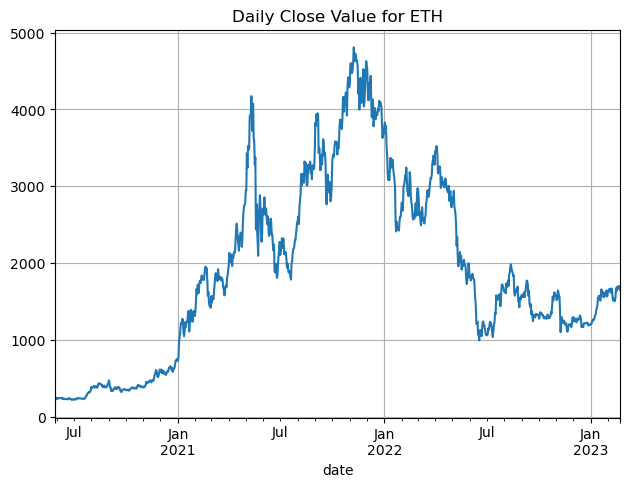

In [4]:
def get_ticker_data(key):
    cc = CryptoCurrencies(key=key, output_format='pandas')
    data, meta_data = cc.get_digital_currency_daily(symbol='ETH', market='USD')
    
    data['4b. close (USD)'].plot()
    plt.tight_layout()
    plt.title('Daily Close Value for ETH')
    plt.grid()
    plt.show()
    
    return data, meta_data
key = "Insert Key Here"

    
data, meta = get_ticker_data(key)

## Check data is in a Pandas dataframe and is monotonically increasing by DateTime Index.

In [3]:
type(data)

pandas.core.frame.DataFrame

In [4]:
series = data['4b. close (USD)'][::-1]
series_exp = series[0:len(series)]

In [5]:
sktime.datatypes.check_raise(series, mtype='pd.Series')

True

## Check for Stationarity
If p-value < .05 we can safely interpret that to mean the data is stationary.

In [6]:
X = series.values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
 print('\t%s: %.3f' % (key, value))

ADF Statistic: -1.811336
p-value: 0.374848
Critical Values:
	1%: -3.437
	5%: -2.864
	10%: -2.568


We can not conclude the data is stationary. Therefore, an ARIMA model is used to handle the non-stationary aspects of the series through differencing.

## Fitting and Predicting

Using autoARIMA to determine best P, D, and Q parameters, fit the model to previous data and predict the next day's value.

In [7]:
warnings.filterwarnings('ignore')

series_train, y_test = temporal_train_test_split(series_exp, test_size = .001)
series_train.index = pd.DatetimeIndex(series_train.index, freq="D")
test_indices = y_test.index

fh = ForecastingHorizon(test_indices, is_relative=False)
forecaster = AutoARIMA(start_p=0, max_p=3, seasonal= False)

forecaster.fit(series_train)
y_pred = forecaster.predict(fh)

error = mean_absolute_percentage_error(y_test, y_pred)

y_resid = y_pred - y_test

print('Prediction: ' + str(y_pred) + '\n', 'Actual: ' + str(y_test) + '\n')
print('Residual: ' + str(y_resid) + '\n')
print("MAPE: " + str(error))

Prediction: 2023-02-22    1663.517437
dtype: float64
 Actual: date
2023-02-22    1652.97
Name: 4b. close (USD), dtype: float64

Residual: 2023-02-22    10.547437
dtype: float64

MAPE: 0.006380900258949557


## Evaluation of Model
Predict the next day's closing price for the last 30 days and compare to actual prices.

In [15]:
warnings.filterwarnings('ignore')
df_preds = pd.DataFrame()
df_resids = pd.DataFrame()

for i in range (30):
    series_train, y_test = temporal_train_test_split(series_exp[0:-i or None], test_size = .001)
    series_train.index = pd.DatetimeIndex(series_train.index, freq="D")
    test_indices = y_test.index
    fh = ForecastingHorizon(test_indices, is_relative=False)
    forecaster1 = AutoARIMA(start_p=0, max_p=3, seasonal= False)
    forecaster1.fit(series_train)
    y_pred = forecaster.predict(fh)
    y_resid = y_pred - y_test
    df_preds = pd.concat([df_preds, y_pred], axis="rows")
    df_resids = pd.concat([df_resids, y_resid], axis="rows")

## Plot for comparing actual to predicted values and the residuals of those days.

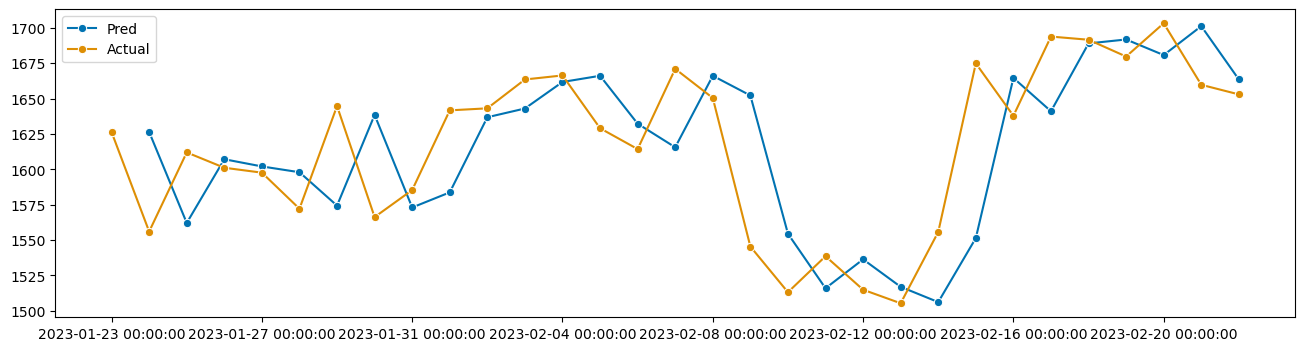

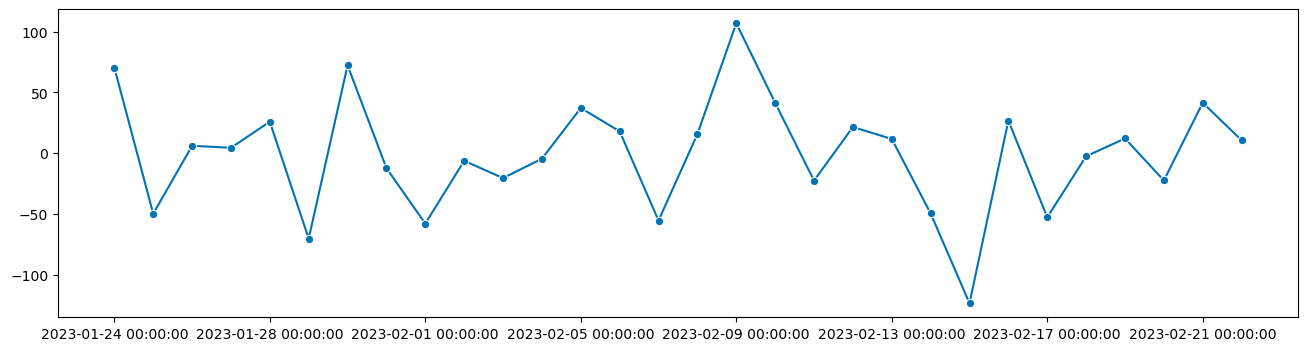

In [26]:
df_preds = df_preds.iloc[::-1]
df_resids = df_resids.iloc[::-1]
fig1, ax1 = plot_series(df_preds, series_exp[-31:], labels= ["Pred", "Actual"])
fig,ax = plot_series(df_resids)

## Predicting Tomorrow's Price

In [17]:
test_index = len(series)
today = series[-1:].index
print(today)
tom = today + datetime.timedelta(days = 1)
print(tom)

DatetimeIndex(['2023-02-22'], dtype='datetime64[ns]', name='date', freq=None)
DatetimeIndex(['2023-02-23'], dtype='datetime64[ns]', name='date', freq=None)


In [18]:
fh = ForecastingHorizon(tom, is_relative=False)
day_predict = forecaster.predict(fh)

In [19]:
print(series[-1:])
print(day_predict)

date
2023-02-22    1652.97
Name: 4b. close (USD), dtype: float64
2023-02-23    1663.192952
dtype: float64


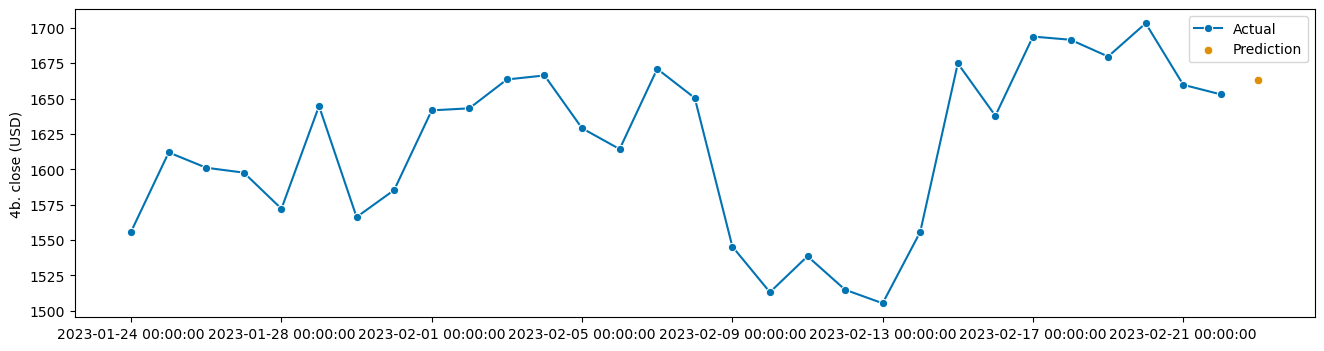

In [20]:
fig2, ax2 = plot_series(series[-30:], day_predict, labels= ["Actual", "Prediction"])